#### problem
Assuming a Gotchi with Kinship X, 
that channels Y amount of times per day (deduced by the level of altar), 
with a spillover of Z %, 
and a collection of the spillover of S % (which is directly related to the radius of spillover and the size of the plot), 
what is the optimum level of altar for each plot size?




TODO
- [ ] call API for fud, fomo, alpha, kek factors
- [ ] code for multiple parcels

Thoughts

- To begin with, we would create level 1 altaar on all the parcels, because it has 0 cost
- We would then start upgrading one of the altaars from level 1 to level 2
- Once the upgrading is done, then we need to take a decision whether to upgrade the same altaar to level 3, or decide to upgrade any other altaar to level 2
- This decision(upgrade same or some other altaar) would have to be taken after each upgrade
- If the game is allowed to run for infinite time, then we could simply keep on upgrading all till max level(level 9)
- But we have time constraint T (days for which game would be played). Hence for T days, there would be a particular order of upgrade which would be optimal for us.
-  We also have a constraint on the number of gotchi's, so it may even not make sense to upgrade more than what gotchi's could collect.

for each altaar $A_i$, number of times it could be channeled in a day $r_i$

$$ \sum_i r_i <=  \sum gotchi$$ 

### initializations

In [1]:
import math
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import requests


In [2]:
BASE_RATE = [20, 10, 5, 2] #ordered by FUD, FOMO, ALPHA, KEK
plot_size_array = [1, 2, 4, 8, 16, 32, 64]
SPILLOVER_COLLECTION_RATE = 0.3 # this will depend on radius and size of parcel

In [3]:
URL = "https://api.coingecko.com/api/v3/simple/price?ids=aavegotchi-fud%2Caavegotchi-fomo%2Caavegotchi-alpha%2Caavegotchi-kek%2Caavegotchi&vs_currencies=usd"
result = requests.get(url = URL).json()


In [4]:
result

{'aavegotchi-alpha': {'usd': 0.203206},
 'aavegotchi-fomo': {'usd': 0.04295478},
 'aavegotchi-kek': {'usd': 0.334724},
 'aavegotchi-fud': {'usd': 0.02107848},
 'aavegotchi': {'usd': 1.65}}

In [5]:
fud_factor = 1.0
fomo_factor = result['aavegotchi-fomo']['usd']/result['aavegotchi-fud']['usd']
alpha_factor = result['aavegotchi-alpha']['usd']/result['aavegotchi-fud']['usd']
kek_factor = result['aavegotchi-kek']['usd']/result['aavegotchi-fud']['usd']

In [6]:
fud_factor, fomo_factor, alpha_factor, kek_factor

(1.0, 2.0378499777972605, 9.640448457384023, 15.879892667782498)

In [7]:
# fud_factor = 1.0
# fomo_factor = 2.0
# alpha_factor = 4.0
# kek_factor = 10.0

In [8]:
CHANNELING_RATE_IN_HOURS = {
    1:24, 2:18, 3:12, 4:8, 
    5:6, 6:4, 7:3, 8:2, 9:1
}

In [9]:
altaar_cost_df = pd.read_csv("data/altaar_cost.csv")
altaar_cost_df = altaar_cost_df.replace(',','', regex=True)

In [10]:
altaar_cost_df.head(12)

,Level,FUD,FOMO,ALPHA,KEK,Built Time (Blocks),Buid Time (Days)
0,1,0,0,0,0,0,0.0
1,2,300,150,75,10,65000,1.7
2,3,600,300,150,20,160000,4.1
3,4,1000,750,375,100,320000,8.1
4,5,2000,1500,750,200,475000,12.1
5,6,4000,3000,1500,400,630000,16.0
6,7,5000,7500,3750,1500,1250000,31.8
7,8,10000,15000,7500,3000,1900000,48.4
8,9,20000,30000,15000,6000,3200000,81.5


In [11]:
altaar_cost_df.columns

Index(['Level', 'FUD', 'FOMO', 'ALPHA', 'KEK', 'Built Time (Blocks)',
       'Buid Time (Days) '],
      dtype='object')

In [12]:
#altaar_cost_df["new days"] = altaar_cost_df["Built Time (Blocks)"].apply(lambda x: int(x)*2.2/(60*60*24))

In [13]:
altaar_built_time_dict = { altaar_cost_df['Level'][i]: altaar_cost_df['Buid Time (Days) '][i] for i in range(altaar_cost_df.shape[0]) }
altaar_built_time_dict

{1: 0.0, 2: 1.7, 3: 4.1, 4: 8.1, 5: 12.1, 6: 16.0, 7: 31.8, 8: 48.4, 9: 81.5}

In [14]:
altaar_built_cost_dict = { altaar_cost_df['Level'][i]: 
                          fud_factor*int(altaar_cost_df['FUD'][i])+
                          fomo_factor*int(altaar_cost_df['FOMO'][i])+
                          alpha_factor*int(altaar_cost_df['ALPHA'][i])+
                          kek_factor*int(altaar_cost_df['KEK'][i]) 
                          for i in range(altaar_cost_df.shape[0]) }
altaar_built_cost_dict


{1: 0.0,
 2: 1487.510057651216,
 3: 2975.020115302432,
 4: 7731.544921645203,
 5: 15463.089843290407,
 6: 30926.179686580814,
 7: 80255.3955503433,
 8: 160510.7911006866,
 9: 321021.5822013732}

In [15]:
yield_at_base_rate = fud_factor*BASE_RATE[0]+ \
                    fomo_factor*BASE_RATE[1] + \
                    alpha_factor*BASE_RATE[2] + \
                    kek_factor*BASE_RATE[3]

In [16]:
"""
computing all possible sizes of plots available.
"""

all_sizes = []
for x in plot_size_array:
    for y in plot_size_array:
        all_sizes.append(tuple(sorted((x,y))))
all_sizes = sorted(list(set(all_sizes)))

all_sizes = [(8,8), (16,16), (32,64)] # predetermined sizes of parcels in gotchiverse

### helper functions

In [17]:
"""
this function will be used once there is more information how spill varies according to radius
"""
def spill_radius_function(x_len, y_len):
    tmp_array = [[0]*x_len for i in range(y_len)]
    mid_x = x_len/2.0
    mid_y = y_len/2.0
    
    for i in range(x_len):
        for j in range(y_len):
            pixel_x = i+0.5
            pixel_y = j+0.5
            dist_from_mid = math.sqrt(math.pow(mid_x-pixel_x, 2) + math.pow(mid_y-pixel_y, 2))
            
            tmp_array[i][j] = dist_from_mid
    
    return tmp_array

spill_radius_function(3,3)

[[1.4142135623730951, 1.0, 1.4142135623730951],
 [1.0, 0.0, 1.0],
 [1.4142135623730951, 1.0, 1.4142135623730951]]

In [18]:
"""
this is a simple spill collection function which depends on size of parcel
spillover collection is 1 for 64X64
splillover collection for k X k = (k/64)*(k/64)
"""

def spill_collection_rate(x_len, y_len):
    
    return (x_len/64)*(y_len/64)


In [19]:
"""
This function computes yield which an altaar which generate in 1 day, given the following parameters
1. kinships of all the available gotchis
2. the level of altaar
3. dimension of the parcel

yield = frequency_of_channel x base_rate_yield x channeling_modifier x spillover_rate x collection_rate
"""

def get_yield_for_the_day(gotchi_kinship_array, altaar_level, parcel_dim):
    x, y = parcel_dim
    
    spillover_rate = (50 - (altaar_level-1)*5)/100.0
    
    channeling_modifier_array = sorted([math.sqrt(ele/50) for ele in gotchi_kinship_array], reverse=True) #start by using gotchi's who have more kinship
    
    channel_frequency = int(24/CHANNELING_RATE_IN_HOURS[altaar_level])
    
    total_yield = 0
    for i in range(min(len(gotchi_kinship_array), channel_frequency)):
        total_yield += int(channeling_modifier_array[i]*yield_at_base_rate*(1-spillover_rate) * spill_collection_rate(x, y))
    
    return total_yield

get_yield_for_the_day([500, 500], 1, [64,64])


190

In [20]:
"""
TODO: need to implement this function covering all the types of scenarios
1. day will be divided into 2 parts. one with the original altar, 2nd with the upgraded altar
2. gotchi's need to make a choice which altaar to channel, depending on how many channel frequency are available in each
3. preferably gotchi's should channel the upgraded altar
"""
def get_yield_for_the_upgrade_day(gotchi_kinship_array, altaar_level, parcel_dim, pending_built_time):
    # using the same function as of now, will work on this function later
    return get_yield_for_the_day(gotchi_kinship_array, altaar_level, parcel_dim)

get_yield_for_the_upgrade_day([500, 500], 1, [64,64], 0.3)


190

In [21]:
def future_yield_by_current_altaar(gotchi_kinship_array, altaar_level, parcel_dim, num_days):
    return get_yield_for_the_day(gotchi_kinship_array, altaar_level, parcel_dim)*num_days


### GAMEPLAYS

#### gameplay v2

In [22]:
"""
This gameplay assumes you keep on upgrading the altaar whenever possible
It returns the sequence of cumulative yield generated over the time
"""

def gameplay_v2(gotchi_kinship_array, num_days, current_altaar, parcel_dim):
    
    total_yield_by_days = []
    generated_yield_by_days = [] # this doesnt included the cost of construction of altaar
        
    pending_built_time_for_next_altaar = math.inf if current_altaar == 9 else altaar_built_time_dict[current_altaar+1]
    
    total_yield_till_now = 0
    generated_yield_till_now = 0
    
    for i in range(num_days):
        
        if pending_built_time_for_next_altaar <=1: #altaar can be made current day
            total_yield_till_now += get_yield_for_the_upgrade_day(gotchi_kinship_array, current_altaar, parcel_dim, pending_built_time_for_next_altaar)
            generated_yield_till_now += get_yield_for_the_upgrade_day(gotchi_kinship_array, current_altaar, parcel_dim, pending_built_time_for_next_altaar)

            total_yield_till_now -= altaar_built_cost_dict[current_altaar+1]  #reducing the total cost for building the altaar
            
            if current_altaar == 8:
                current_altaar = current_altaar + 1
                pending_built_time_for_next_altaar = math.inf
            elif current_altaar == 9:
                pending_built_time_for_next_altaar = math.inf
            else:
                current_altaar = current_altaar + 1
                pending_built_time_for_next_altaar = altaar_built_time_dict[current_altaar+1]

        
        else:
            total_yield_till_now += get_yield_for_the_day(gotchi_kinship_array, current_altaar, parcel_dim)
            generated_yield_till_now += get_yield_for_the_day(gotchi_kinship_array, current_altaar, parcel_dim)

            pending_built_time_for_next_altaar -= 1
            
        #print("day {}, current level {}, pending time {}".format(i+1, current_altaar, pending_built_time_for_next_altaar))
        
        total_yield_by_days.append(total_yield_till_now)
        generated_yield_by_days.append(generated_yield_till_now)
        gotchi_kinship_array = [ele+2 for ele in gotchi_kinship_array]

    return total_yield_by_days, generated_yield_by_days



num_days = 1000
total_yield_by_days, generated_yield_by_days = gameplay_v2(gotchi_kinship_array=[500, 500, 500, 500, 500],
            num_days=num_days,
            current_altaar=1,
            parcel_dim = [64, 64]
           )
#print("total yield {}".format(total_yield_by_days))

indices_list = list(range(0, num_days, 20))
res = list(np.array(total_yield_by_days)[indices_list])  # this we are doing to reduce the number of things we need to plot
res1 = list(np.array(generated_yield_by_days)[indices_list])


Text(0, 0.5, 'Yield')

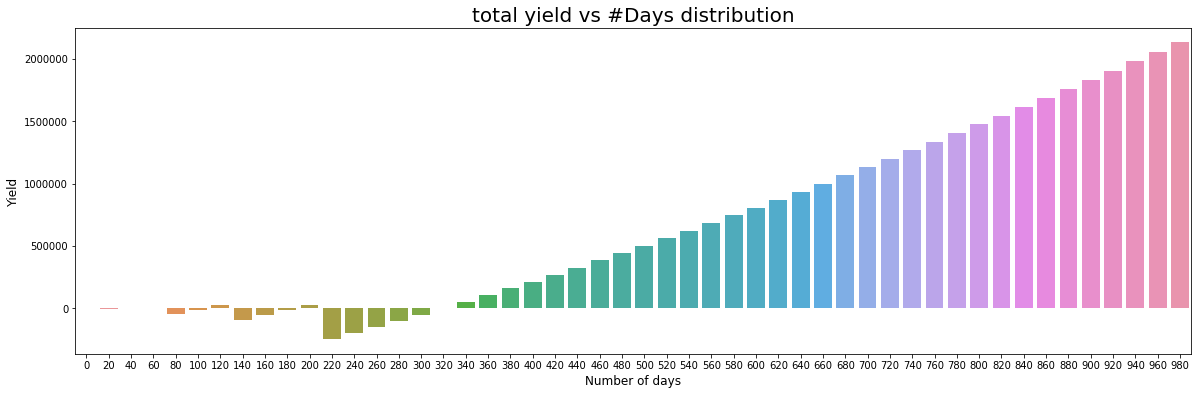

In [23]:
fig, ax = plt.subplots(figsize=(20,6))         # Sample figsize in inches
#plt.bar(indices_list, res)
sns.barplot(indices_list, res)
plt.title('total yield vs #Days distribution', fontsize = 20) # title with fontsize 20
plt.xlabel('Number of days', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('Yield', fontsize = 12) # y-axis label with fontsize 15

This graph show the yields generated by the gotchi's minus the construction cost associated with altaars

Text(0, 0.5, 'Yield')

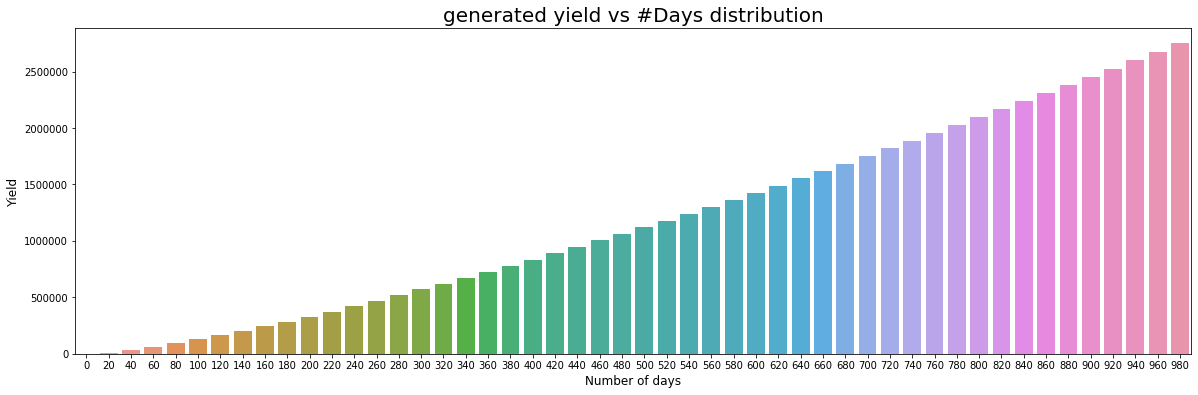

In [24]:
fig, ax = plt.subplots(figsize=(20,6))         # Sample figsize in inches
#plt.bar(indices_list, res)
sns.barplot(indices_list, res1)
plt.title('generated yield vs #Days distribution', fontsize = 20) # title with fontsize 20
plt.xlabel('Number of days', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('Yield', fontsize = 12) # y-axis label with fontsize 15

#### gameplay v3

In [25]:
"""
Given (a) number of days (b) what could be the maximum altaar built,
this function computes the maximum yield possible, and till what level should the altaar be upgraded
"""
def gameplay_v3(gotchi_kinship_array, num_days, current_altaar, parcel_dim, max_allowed_altaar):

    pending_built_time_for_next_altaar = math.inf if current_altaar >= max_allowed_altaar else altaar_built_time_dict[current_altaar+1]
    
    total_yield_till_now = 0
    
    max_expected_yield = 0
    max_yield_level = 1
    
    for i in range(num_days):
        
        if pending_built_time_for_next_altaar <=1: #altaar can be made current day
            total_yield_till_now += get_yield_for_the_upgrade_day(gotchi_kinship_array, current_altaar, parcel_dim, pending_built_time_for_next_altaar)
            total_yield_till_now -= altaar_built_cost_dict[current_altaar+1]  #reducing the total cost for building the altaar
            
            if current_altaar == max_allowed_altaar-1:
                current_altaar = current_altaar + 1
                pending_built_time_for_next_altaar = math.inf
            elif current_altaar == max_allowed_altaar:
                pending_built_time_for_next_altaar = math.inf
            else:
                current_altaar = current_altaar + 1
                pending_built_time_for_next_altaar = altaar_built_time_dict[current_altaar+1]

        else:
            total_yield_till_now += get_yield_for_the_day(gotchi_kinship_array, current_altaar, parcel_dim)
            pending_built_time_for_next_altaar -= 1
            
        #print("day {}, current level {}, pending time {}".format(i+1, current_altaar, pending_built_time_for_next_altaar))
        
        future_yield = future_yield_by_current_altaar(gotchi_kinship_array, current_altaar, parcel_dim, num_days-i-1)
                
        if total_yield_till_now + future_yield > max_expected_yield:
            max_expected_yield = total_yield_till_now + future_yield
            max_yield_level = current_altaar
        
        gotchi_kinship_array = [ele+2 for ele in gotchi_kinship_array]

    return max_expected_yield, max_yield_level

    
total_yield, altaar_level = gameplay_v3(gotchi_kinship_array=[500, 500],
            num_days=300,
            current_altaar=1,
            parcel_dim = [32, 64],
            max_allowed_altaar=3                                                
           )

#print(total_yield)


In [26]:
DAYS = [10*(i+1) for i in range(25)]

result_array = [[0]*len(DAYS) for i in range(9)]
result_array_1 = [[0]*len(DAYS) for i in range(9)]


for level in range(9):
    for i in range(len(DAYS)):
        result_array[level][i], result_array_1[level][i] = gameplay_v3(gotchi_kinship_array=[500, 500],
                                            num_days=DAYS[i],
                                            current_altaar=1,
                                            parcel_dim = [32, 32],
                                            max_allowed_altaar=level+1)

Text(159.0, 0.5, 'max allowed level')

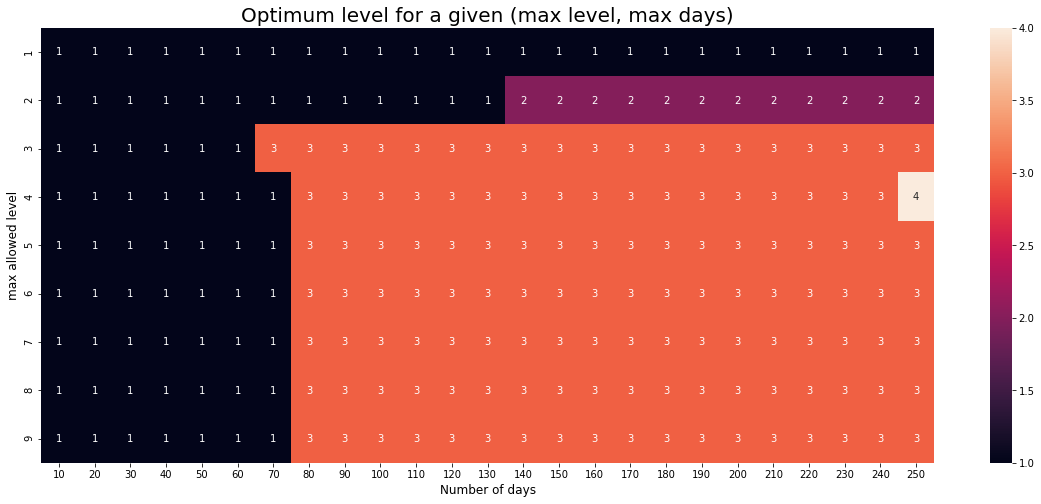

In [27]:
#uniform_data = np.array(result_array)/100. #np.random.rand(7, 7)
uniform_data = np.array(result_array_1)

fig, ax = plt.subplots(figsize=(20,8))         # Sample figsize in inches
ax = sns.heatmap(uniform_data, annot=True, xticklabels=DAYS, yticklabels=range(1,10))
plt.title('Optimum level for a given (max level, max days)', fontsize = 20) # title with fontsize 20
plt.xlabel('Number of days', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('max allowed level', fontsize = 12) # y-axis label with fontsize 15

What does this graph says? <br>
The above graph helps you decide what level of altaar should you build provided you know about the number of days you are going to play the game.

TODO: <br>
Need to figure out why a smaller level appears below the higher level at some parts in the graph

#### gameplay v4

here we are trying to plot optimum level for plot size vs days distribution

In [28]:
all_sizes

[(8, 8), (16, 16), (32, 64)]

In [29]:
DAYS = [10*(i+1) for i in range(25)]

result_array = [[0]*len(DAYS) for i in range(len(all_sizes))]


for k, parcel_dim in enumerate(all_sizes):
    for i, day in enumerate(DAYS):

        max_yield = 0
        max_level = 1

        for level in range(9):
            myyield, mylevel = gameplay_v3(gotchi_kinship_array=[500],
                                                num_days=day,
                                                current_altaar=1,
                                                parcel_dim = parcel_dim,
                                                max_allowed_altaar=level+1)

            if myyield > max_yield:
                max_yield = myyield
                max_level = mylevel
        
        result_array[k][i] = max_level

Text(159.0, 0.5, 'parcel size')

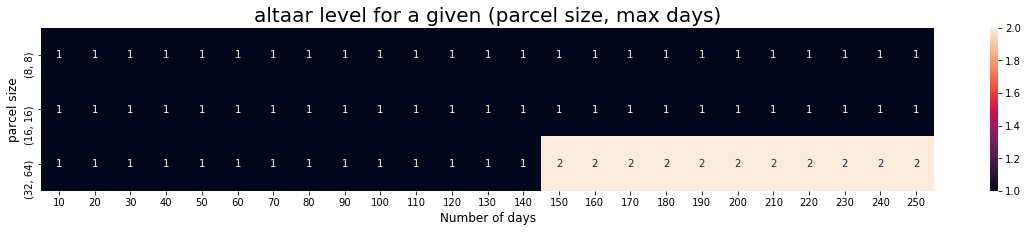

In [30]:


uniform_data = np.array(result_array)

fig, ax = plt.subplots(figsize=(20,3))         # Sample figsize in inches
ax = sns.heatmap(uniform_data, annot=True, xticklabels=DAYS, yticklabels=all_sizes)
plt.title('altaar level for a given (parcel size, max days)', fontsize = 20) # title with fontsize 20
plt.xlabel('Number of days', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('parcel size', fontsize = 12) # y-axis label with fontsize 15

#### gameplay v5

In [31]:
# need to find optimum altaars to construct for a given number of parcels, number of gotchis, and given time.
# make a graph in which y axis has different plots, and x axis has time. 
# Label each block with how many altaars of what levels


# each gotchi would either be idle for now, or would be collecting from some altaar
# find marginal utility of new upgrades for each gotchi for that given time period


In [32]:
all_sizes

[(8, 8), (16, 16), (32, 64)]

In [ ]:
50000 days
24 parcels -- 
24 gotchis -- [multiple kinships]






24 parcels
40 gotchis



In [ ]:
"""
initialize all parcels by level 1
check the amount of gotchi's left

if no gotchis are pending then we are good
if gotchis are pending --> choose whichever element of the 3 matrix is giving highest yield for that level
check how many gotchis are still left.

if there is a max limit for the gotchis available

"""

In [165]:
# this would be a 3 dimensional array. 
# 1st element would number of parcels of size 8x8
# 2nd element would number of parcels of size 16x16
# 3rd element would number of parcels of size 32x64
parcel_input = [1, 0, 0]
gotchi_kinship_array=[500, 500]
days = 200

In [166]:
# Y1, Y2, Y3 are the arrays yields at different level for T(num days) for a given altaar
# it would be calculated using the gameplay v3

yield_dict = {
    (8, 8): [gameplay_v3(gotchi_kinship_array=[500],
                                            num_days=days,
                                            current_altaar=1,
                                            parcel_dim = [8, 8],
                                            max_allowed_altaar=level+1)
             for level in range(9)],
    (16, 16): [gameplay_v3(gotchi_kinship_array=[500],
                                            num_days=days,
                                            current_altaar=1,
                                            parcel_dim = [16, 16],
                                            max_allowed_altaar=level+1)
             for level in range(9)],
    (32, 64): [gameplay_v3(gotchi_kinship_array=[500],
                                            num_days=days,
                                            current_altaar=1,
                                            parcel_dim = [32, 64],
                                            max_allowed_altaar=level+1)
             for level in range(9)],
}

yield_dict

{(8, 8): [(595, 1),
  (400, 1),
  (400, 1),
  (400, 1),
  (400, 1),
  (400, 1),
  (400, 1),
  (400, 1),
  (400, 1)],
 (16, 16): [(2701, 1),
  (2200, 1),
  (2200, 1),
  (2200, 1),
  (2200, 1),
  (2200, 1),
  (2200, 1),
  (2200, 1),
  (2200, 1)],
 (32, 64): [(22319, 1),
  (23056.489942348784, 2),
  (22252.469827046352, 3),
  (19492.489942348784, 2),
  (19492.489942348784, 2),
  (19492.489942348784, 2),
  (19492.489942348784, 2),
  (19492.489942348784, 2),
  (19492.489942348784, 2)]}

In [167]:
class MyParcel:
    level = 1
    dim = (8, 8)
    yield_array = [0]*9
    def __init__(self, level, dim):
        self.level = 1
        self.dim = dim
        self.yield_array = yield_dict[dim]

    def get_next_level_yield(self):
        assert self.level < 8, "9 is the maximum available level"
        return self.yield_array[self.level+1][0]
        

In [172]:
Parcels = []

for i in range(parcel_input[0]):
    Parcels.append(MyParcel(1, (8, 8)))
    
for i in range(parcel_input[1]):
    Parcels.append(MyParcel(1, (16, 16)))
    
for i in range(parcel_input[2]):
    Parcels.append(MyParcel(1, (32, 64)))
    
    
Parcels

In [169]:
num_available_gotchis = len(gotchi_kinship_array) - len(Parcels)
num_available_gotchis

1

In [170]:
if num_available_gotchis <= 0:
    print("Allotment has been done. Nothing more to do")

In [171]:
while(num_available_gotchis > 0):
    # check which is best among the upgradeable levels
    next_upgradeable_index = 0
    max_upgradeable_yield = Parcels[0].get_next_level_yield()
    
    print("new loop")
    print("num_available_gotchis is {}".format(num_available_gotchis))
    
    for i in range(len(Parcels)):
        next_level_yield = Parcels[i].get_next_level_yield()
        print("{} --> {}".format(i, next_level_yield))
        
        if next_level_yield > max_upgradeable_yield:
            max_upgradeable_yield = next_level_yield
            next_upgradeable_index = i
    
    
    #upgrade the index thus achieved, and reduce the num available gotchis
    Parcels[next_upgradeable_index].level += 1
    
    
    channel_frequency = int(24/CHANNELING_RATE_IN_HOURS[altaar_level])
    extra_available_channeling_slots = int(24/CHANNELING_RATE_IN_HOURS[next_upgradeable_index]) - int(24/CHANNELING_RATE_IN_HOURS[next_upgradeable_index - 1])
    print("extra slots --> {}".format(extra_available_channeling_slots))
    num_available_gotchis -= extra_available_channeling_slots
    

new loop
num_available_gotchis is 1
0 --> 400


KeyError: 0

In [163]:
#print result

result = {}
for i in range(len(Parcels)):
    if str(Parcels[i].dim) in result:
        result[str(Parcels[i].dim)].append(Parcels[i].level)
    else:
        result[str(Parcels[i].dim)] = [Parcels[i].level]
    print("size {} level constructed {}".format(Parcels[i].dim, Parcels[i].level))

size (8, 8) level constructed 1


In [164]:
result

{'(8, 8)': [1]}

In [ ]:
gotchi_array = request.args.get('gotchi_array')
parcel_array = request.args.get('parcel_array')
days = int(request.args.get('days'))

parcel_input = list(map(int, parcel_array.split(",")))

gotchi_kinship_array = list(map(int, gotchi_array.split(",")))


total_parcels = sum(parcel_input)
total_gotchis = len(gotchi_kinship_array)

Parcels = []

for i in range(parcel_input[2]):
    Parcels.append(MyParcel_1(0, (32, 64), 0))

for i in range(parcel_input[1]):
    Parcels.append(MyParcel_1(0, (16, 16), 0))

for i in range(parcel_input[0]):
    Parcels.append(MyParcel_1(0, (8, 8), 0))

gotchi_kinship_array.sort(reverse=True)

temp = total_gotchis

while temp > 0:
    for parcel in Parcels:
        parcel.num_gotchi += 1
        temp -= 1

        if temp == 0:
            break


counter = 0
for parcel in Parcels:
    for i in range(parcel.num_gotchi):
        parcel.gotchi_kinship_array.append(gotchi_kinship_array[counter])
        counter +=1 


for parcel in Parcels:
    #print("dim {} --> num gotchi {} --> {}".format(parcel.dim, parcel.num_gotchi, parcel.gotchi_kinship_array))

    _, parcel.level = gameplay_v3(gotchi_kinship_array=parcel.gotchi_kinship_array,
                num_days=days,
                current_altaar=1,
                parcel_dim = parcel.dim,
                max_allowed_altaar=9)


result = {}
for i in range(len(Parcels)):
    if str(Parcels[i].dim) in result:
        result[str(Parcels[i].dim)].append(Parcels[i].level)
    else:
        result[str(Parcels[i].dim)] = [Parcels[i].level]
    print("size {} level constructed {}".format(Parcels[i].dim, Parcels[i].level))